**Соревнование**

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

**Цель проекта**

В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.
рсив*

**Ноутбук**

В рамках проекта был написан код, содержание которого я опишу ниже.

*3 основных раздела:*


1.   EDA
2.   Features Enginering
3.   Model ML

EDA. В рамках раздела я изучал структуру данных, распределение, взаимосвязи. На основе данных можно было детальнее рассмотреть данные о покупке какого0либо товара или поведения группы клиентов (по возрасту, полу и тд, если таковые бы имелись). Но в рамках проекта я нашел точки, на основе которых проводился этап Features Enginering.

Features Enginering. Главной задачей было создание target переменной. Изначально мной была выбрана следующая логика: Если в dataset есть дубли связки User_id и cart, то мы будем рекомендовать клиенту снова купить этот товар. В рамках теста я пересмотрел логику переменной Target и, как оказалось, смог улучшить результат. Логика выглядела следующим образом: Target = 1 в тех случаях, если клиент покупал этот товар 3 и более раза. Эта стратегия принисла увеличение качества метрик. Далее по коду идет обработка Target переменной, например я исключил предложения тех товаров, которые пользуются минимальным спросом или не покупались за последний год. Далее были созданы переменные, аналог OHE - я выбрал топ 5 товаров по всей выборке и каждому товару предоставил индивидуальную переменную. Если товар входил в топ 5 товаров - он получал свой "флаг" 1 в одной из этих 5 переменных. Далее создал бинарную переменную, которая отображает - находится ли товар в топ 15 по всей выборке. Целью этих фич было направление модели на рекомендацию самых популярных товаров, но в отличи от ограничения рекомендации товаров с низким рейтингом - эти фичи не гарантировали, что товар будет предложен. Так же в рамках раздела я добавил каждому клиенту его любимый продукт. Так же в разделе можно заметить, что я проводил корреляцию признаков, удалял некоторые фичи, которые оказались бесполезными. И подготовил тестовые датафреймы, где удалял некоторые переменные (это понижало скор, поэтмоу ML происходил на полном датасете)

Model ML. В рамках раздела я протестировал 3 модели - Логистическую регрессию, DecisionTreeClassifier, случайный лес. Так же были проведены некоторые эксперементы. Был использован GridSearchCV для поиска новых параметров. В заключении, в разделе to_sumbit, было подготовленно предсказание для Kaggle.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import figure
import io
import math

In [2]:
from matplotlib import pyplot as plt
plt.style.use('dark_background')

# Загрузим dataframe

In [3]:
!gdown --id 1OlaAX5t6g-4XAX0o2z7rshkeLcIJmBAU

Downloading...
From: https://drive.google.com/uc?id=1OlaAX5t6g-4XAX0o2z7rshkeLcIJmBAU
To: /content/train.csv
100% 89.6M/89.6M [00:00<00:00, 122MB/s]


In [4]:
!gdown --id 17UcpdKBgeg2RequEqGXZojRy1jJ13UMe

Downloading...
From: https://drive.google.com/uc?id=17UcpdKBgeg2RequEqGXZojRy1jJ13UMe
To: /content/sample_submission.csv
100% 8.64M/8.64M [00:00<00:00, 98.6MB/s]


In [5]:
train = pd.read_csv('train.csv') 

In [6]:
subm = pd.read_csv('sample_submission.csv') 

data DF:

* user_id - уникальный id пользователя
* order_completed_at - дата заказа
* cart - список уникальных категорий (category_id), из которых состоял заказ

In [7]:
train.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


subm DF:
* id - ID,покупка
* target


In [8]:
subm.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


## Обработка subm DF

Преобразуем subm в датафрейм



In [9]:
temp = subm.copy()

In [10]:
temp['user_id'] = subm['id'].apply(lambda x: int(x.split(';')[0]))
temp['cart'] = subm['id'].apply(lambda x: int(x.split(';')[1]))

In [11]:
temp

,id,target,user_id,cart
0,0;133,0,0,133
1,0;5,1,0,5
2,0;10,0,0,10
3,0;396,1,0,396
4,0;14,0,0,14
...,...,...,...,...
790444,19998;26,0,19998,26
790445,19998;31,0,19998,31
790446,19998;29,1,19998,29
790447,19998;798,1,19998,798


In [12]:
temp.drop(['id', 'target'], inplace = True, axis = 1)

# EDA

## DataSet

In [13]:
train.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


In [15]:
temp.head()

,user_id,cart
0,0,133
1,0,5
2,0,10
3,0,396
4,0,14


In [16]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  790449 non-null  int64
 1   cart     790449 non-null  int64
dtypes: int64(2)
memory usage: 12.1 MB


In [17]:
# Есть ли пропуски в train
train.isna().sum()

user_id               0
order_completed_at    0
cart                  0
dtype: int64

## Посмотрим на фичи tarin

### user_id

In [18]:
# Сколько клиентов в выборке
len(train['user_id'].unique())

20000

In [19]:
# Сколько в среднем делает заказов 1 клиент
train.groupby('user_id')['cart'].count().mean()

156.1532

In [20]:
# Сколько товаров купил клиент в самой маленькой закупке
train.groupby('user_id')['cart'].count().min()

3

In [21]:
# Медиана кол-ва заказов в целом по выборке
train.groupby('user_id')['cart'].median().mean()

165.41475

In [22]:
#Сколько заказов делал клиент
train.groupby('user_id')['cart'].count().sort_values(ascending=False)

user_id
380      3508
105      2833
84       2610
3918     2566
1156     2357
         ... 
9127        3
8990        3
14464       3
14664       3
19999       3
Name: cart, Length: 20000, dtype: int64

<Figure size 1620x720 with 0 Axes>

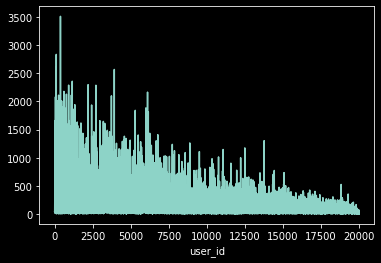

<Figure size 1620x720 with 0 Axes>

In [23]:
# Посмотрим на график: Х - клиент, Y - кол-во покупок
t = train.copy()
t = t.groupby('user_id')['cart'].count().plot()


figure(figsize=(18, 8), dpi=90)


### Catr

In [24]:
# Сколько товаров в выборке
len(train['cart'].unique())

881

In [25]:
# Самые популярные товары
train['cart'].value_counts().head(10)

57     108877
14      93957
61      91543
398     81694
23      71837
84      68715
22      68478
409     59920
17      58840
402     49925
Name: cart, dtype: int64

Самые редкие корзины в выборке

In [26]:
t = train.groupby('cart')['user_id'].count()
min_50 = t[t < 50] 
print (f'Кол-во товаров, которые выбрало до 50 клиентов: {len(min_50)}')

Кол-во товаров, которые выбрало до 50 клиентов: 414


In [27]:
t = train.groupby('cart')['user_id'].count()
min_10 = t[t < 10] 
print (f'Кол-во товаров, которые выбрало до 10 клиентов: {len(min_10)}')

Кол-во товаров, которые выбрало до 10 клиентов: 250


In [28]:
t = train.groupby('cart')['user_id'].count()
min_1 = t[t == 1] 
print (f'Кол-во товаров, которые выбрал только 1 клиент: {len(min_1)}')

Кол-во товаров, которые выбрал только 1 клиент: 78


### Order_completed_at

In [29]:
# Преобразуем к DataTime и посмотрим на дату первого и последнего заказа в выборке


train['order_completed_at'] = pd.to_datetime(train['order_completed_at'])
t = train['order_completed_at']
print(f'Первый заказ: {t.min()}\nПоследний заказ: {t.max()}')

Первый заказ: 2015-03-22 09:25:46
Последний заказ: 2020-09-03 23:45:45


# Fetures Enginering

## Target

Изначально использвалась логика, (код которой находиться в разделе Target 1) - если в связке user_id + cart есть дубль - в этих строках target = 1, что фактически означало, что если клиент купил продукт 2 раза, то мы будем этот продукт рекомендовать к покупке. В новй переменной (раздел Target 2) была пересмотрена логика Target переменой: теперь мы ставем 1 в тех случаях, когда клиент покупал продукт 3 и более раза. На тесте Kaggle Target 2 показал себя лучше, чем базовый вариант, занчительно увеличив score

### Target 2: если клиент покупал товар 3 раза = taget 1

In [30]:
def target_3_times(df):

  """ Функция возвращает набор значений: User_id : choose,
  где choose - продукты, которые клиент выбирал 3 и более раза"""

  users_unique = df['user_id'].unique() 
  target_value = {}
  
  for i in users_unique:
    # Топ покупок клиента. Индексом будут пробукты, а значением - кол-во покупок этого продукта
    t = df[df['user_id'] == i]['cart'].value_counts()

    t_times = t.values # Сколько раз куплен товар
    choose = (t_times > 2).sum() # Сколько товаров куплено более 2х раз

    target_value[i] = list(t.index)[:choose] # Запишем товары купленные более 2х раз

  return target_value

In [31]:
target_value = target_3_times(train)

In [32]:
train['target'] = pd.Series([0 for x in range(len(train.index))]) # Создадим Target

In [33]:
# Переменная с списком топ покупок клиента
train['shopping_list'] = train['user_id'].apply(lambda x: target_value.get(x)) 

In [34]:
# Поставем target = 1 в соотвестивии с логикой
for i in range(len(train)):
    if train['cart'][i] in train['shopping_list'][i]:
      train['target'][i] = 1
    else:
      train['target'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [35]:
train['target'].value_counts()

1    2123794
0     999270
Name: target, dtype: int64

In [36]:
train.drop(['shopping_list'], inplace=True, axis=1)

In [37]:
# train.to_csv('train_whith_target.csv', index = False)

### Target 1: дубль user_id+cart = taget 1

Таргет создаем исходя из идеи:

Ищем дубликаты (это случаи, когда клиент с таким же id заказал товар из той же категории)

* 0 - если нет дубликатов(то есть клиент купил один раз всего товар) 
* 1 - если есть дубликаты(если клиент купил товар несколько раз из этой категории - вероятнее всего он купит еще раз(в будущем)



```
train['target'] = train[['user_id', 'cart']].duplicated(keep=False).apply(lambda x: 1 if x == True else 0)

train['target'].value_counts()

1    2562466
0     560598
Name: target, dtype: int64
```





### Если продукт пользуется минимальным спросом: target = 0

Гепотиза заключается в том, что покупатель, который ранее выбирал менее востребованный продукт, с большей вероятностью купит популярынй продукт, чем тот, котоырй почти ни кто не преобретает. Ограничим положительный таргет у товаров с минимальным спросом

In [38]:
# Создадим DF с переменными ["продукт", "Кол-во покупок"]
t = train['cart'].value_counts()

t_index = list(t.index) # cart
t_values = t.values # count

dict_1 = {'cart': t_index, 'times_to_bye': t_values} 
x_data = pd.DataFrame(dict_1)

In [39]:
t = x_data[x_data['times_to_bye'] < 15]['cart']
low_demand = t.values

Тесты:

* <25 хуже, чем < 15
* <10 хуже, чем < 15

In [40]:
# У выбранных товаров поставим target = 0
for i in range(len(train)):
  if train['cart'][i] in low_demand:
    train['target'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [41]:
low_demand[:5]

array([515, 550, 521, 451, 529])

In [42]:
# Инструмент проверки корректности исправления. У значений cart = low_demand - target = 0
t = train[train['target'] == 0]
t[t['cart'] == 550]

,user_id,order_completed_at,cart,target
1192397,4986,2020-04-12 09:24:34,550,0
1375671,9396,2020-05-02 08:46:03,550,0
1456610,10724,2020-05-09 12:46:11,550,0
1534493,9654,2020-05-16 16:04:42,550,0
1774277,9654,2020-06-05 19:39:18,550,0
1882311,8945,2020-06-13 11:01:32,550,0
1930450,9153,2020-06-16 13:28:58,550,0
2245758,3120,2020-07-07 12:23:58,550,0
2295935,3120,2020-07-10 14:16:51,550,0
2345541,8214,2020-07-14 08:17:30,550,0


### Если товар не покупали в 2020 - рекомендовать не будем

In [43]:
# Поменяем формат столбца
train['order_completed_at'] = pd.to_datetime(train['order_completed_at'])

In [44]:
# Новая переенная, показывающая только год покупки
train['year_of_purchase'] = train['order_completed_at'].apply(lambda x: x.year)

In [45]:
def last_year_of_the_buy(data):
  """Функция возвразает словарь со значениями cart : last buy"""

  cart_unique = data['cart'].unique()
  value_def = {}

  for i in cart_unique:
    max_year = data[data['cart'] == i]['year_of_purchase'].max()
    value_def[i] = max_year

  return value_def

In [46]:
value_year = last_year_of_the_buy(train)

In [47]:
train['max_year'] = pd.Series([0 for x in range(len(train.index))]) # Создадим переменную

In [48]:
train['max_year'] = train['cart'].apply(lambda x: value_year.get(x)) # Переменная с списком топ покупок клиента

In [49]:
def change_target(data):
  """ Функция меняет target на 0 в случае, если товар не покупали в 2020"""
  
  for i in range(len(data)):
    if data['max_year'][i] < 2020:
      data['target'][i] = 0
  
  return data

In [50]:
train = change_target(train) # Обработаем целефвую переменную

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
train.drop(['year_of_purchase', 'max_year'], inplace=True, axis=1) # Лишние переменные

## Добавление новых фичей

### Самый любимый продукт 

In [52]:
def top_buy_dict_func(data):
  """Функция возвращает словарь "Пользователь - любимый продукт (который чаще
  всего встречается в корзине user_id"""
  
  users_unique = data['user_id'].unique() # Список уникальных пользователей
  value = {} # Клиент : Любимый товар

  for i in users_unique:
    t = train[train['user_id'] == i] # DF одного клиента
    t_cart = t['cart'].value_counts().index[0] # Любимый товар
    value[i] = t_cart
  
  return value

In [53]:
#Получим словарь любимых продуктов
top_buy_dict = top_buy_dict_func(train)

In [54]:
# Создадим новую переменную
train['top_user_product'] = train['user_id'].apply(lambda x: top_buy_dict.get(x))

Теперь для temp DF

In [55]:
top_buy_dict_temp = top_buy_dict_func(temp) # Словарь
temp['top_user_product'] = temp['user_id'].apply(lambda x: top_buy_dict_temp.get(x)) 

### Топ 5 товаров (аналог OHE)

Создадим новые переменные "бинарные индикаторы продукта" 

In [56]:
# Список топ 5 товаров
top_5_product_list = train['cart'].value_counts().index[:5]

In [57]:
# Ставим флаг, если купленный товар клиента входит в топ 5 и отмечаем - какой именно товар был куплен
for i in top_5_product_list:
  train[i] = train['cart'].apply(lambda x: 1 if x == i else 0)

То же самое для temp

In [58]:
top_5_product_list_temp = temp['cart'].value_counts().index[:5]

In [59]:
for i in top_5_product_list_temp:
  temp[i] = temp['cart'].apply(lambda x: 1 if x == i else 0)

### Индикатор попадания товара в топ 15

In [60]:
# Топ 15 товаров 
top_15_product_list = train['cart'].value_counts().index[:15]

In [61]:
# Ставим флаг, если купленный товар попадает в топ 15
train['in_top_15'] = train['cart'].apply(lambda x: 1 if x in top_15_product_list else 0)

Тоже самое для temp

In [62]:
top_15_product_list_temp = temp['cart'].value_counts().index[:15]

In [63]:
temp['in_top_15'] = temp['cart'].apply(lambda x: 1 if x in top_15_product_list_temp else 0)

## Корреляция

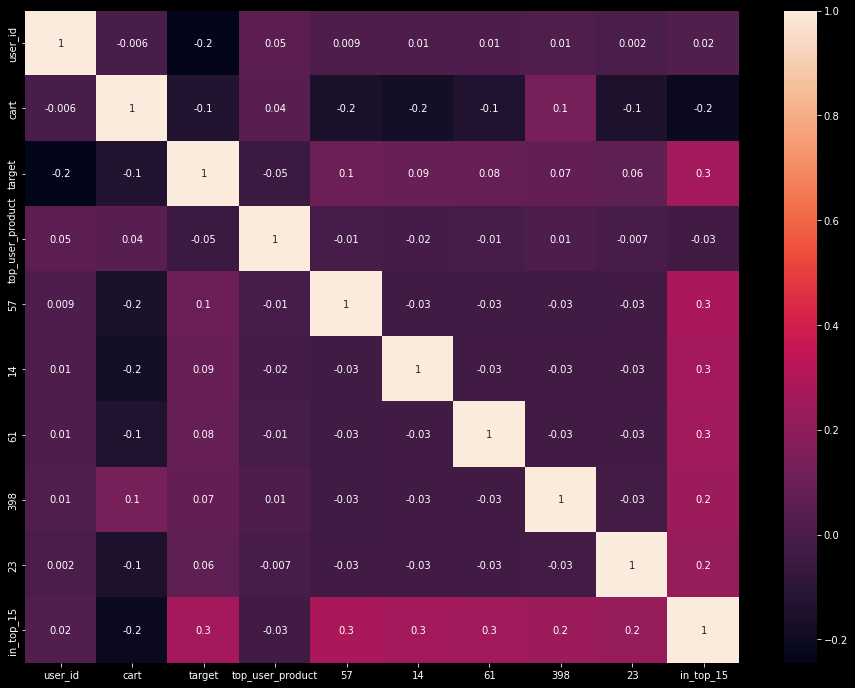

In [64]:
# heatmap для оценки корреляции переменных к default
plt.rcParams['figure.figsize']=16,12
sns.heatmap(train.corr(), annot = True, fmt='.1g')

Некоторые переменные давалине удволетврительную корреляцию, order_year исключим, т.к. в сэмпле нет данных о дате покупки. Так же отмечу, что переменные 57 14 61 398 23 так же дают низкую корреляцию

## Удаление фичей

In [65]:
train

,user_id,order_completed_at,cart,target,top_user_product,57,14,61,398,23,in_top_15
0,2,2015-03-22 09:25:46,399,0,23,0,0,0,0,0,0
1,2,2015-03-22 09:25:46,14,0,23,0,1,0,0,0,1
2,2,2015-03-22 09:25:46,198,0,23,0,0,0,0,0,0
3,2,2015-03-22 09:25:46,88,0,23,0,0,0,0,0,0
4,2,2015-03-22 09:25:46,157,0,23,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,1,23,0,0,0,0,0,0
3123060,12702,2020-09-03 23:45:45,92,0,23,0,0,0,0,0,0
3123061,12702,2020-09-03 23:45:45,431,1,23,0,0,0,0,0,0
3123062,12702,2020-09-03 23:45:45,24,0,23,0,0,0,0,0,0


In [74]:
# pd.toDataTime нет в temp
train = train.drop('order_completed_at', axis=1)

## short_train - DF с уменьшеным кол-вом переменных

In [66]:
train

,user_id,order_completed_at,cart,target,top_user_product,57,14,61,398,23,in_top_15
0,2,2015-03-22 09:25:46,399,0,23,0,0,0,0,0,0
1,2,2015-03-22 09:25:46,14,0,23,0,1,0,0,0,1
2,2,2015-03-22 09:25:46,198,0,23,0,0,0,0,0,0
3,2,2015-03-22 09:25:46,88,0,23,0,0,0,0,0,0
4,2,2015-03-22 09:25:46,157,0,23,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,1,23,0,0,0,0,0,0
3123060,12702,2020-09-03 23:45:45,92,0,23,0,0,0,0,0,0
3123061,12702,2020-09-03 23:45:45,431,1,23,0,0,0,0,0,0
3123062,12702,2020-09-03 23:45:45,24,0,23,0,0,0,0,0,0


In [158]:
short_train = train[['user_id',	'cart',	'target',	'top_user_product',	'in_top_15']]

In [161]:
ultra_short_train = train[['user_id',	'cart',	'target']]

Как и ожидалось - исключения некоторых фич не дало желаемого результата в RandomForestClassifier score

# Model

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.model_selection import GridSearchCV


In [68]:
# Готовим метрики оценки модели, передадим этот список в функцию
scoring = {'roc_auc': 'roc_auc',
           'average_precision': 'average_precision',
           'f1' : 'f1',
           'recall' : 'recall'}

In [69]:
def model_start(model, df, metrics):
  """Функция принимает модель, датафрейм, метрики для cross_validate.
  Внутри делает Split DF, обучает модель, предсказывает тестовые данные.
  Возвращает набор метрик классификации"""

  x = df.drop('target', axis=1).values
  y = df['target'].values
  X_train, X_test, y_train, y_test = train_test_split(x,
                                                      y, 
                                                      test_size=0.2, 
                                                      random_state=42)
  model_in_def = model
  model_in_def.fit(X_train, y_train)
  y_pred = model_in_def.predict(X_test)

  score = cross_validate(model_in_def, X_train, y_train,
                         scoring=metrics, cv=5)
  
  conf_matrix = confusion_matrix(y_test, y_pred)
  T_a_p = score['test_average_precision'].mean()
  r_a = score['test_roc_auc'].mean()
  f1 = score['test_f1'].mean()
  recall = score['test_recall'].mean()

  return print(f'F1-score:\n{f1}\n\nConf_matrix:\n{conf_matrix}\n\nRoc_auc:\n{r_a}\n\nAverage_precision\n{T_a_p}\n\nRecall\n{recall}')

## BaseLine

In [ ]:
original_data = train[['user_id', 'cart', 'target']]

In [ ]:
log_reg = LogisticRegression()

In [ ]:
model_start(log_reg, original_data, scoring)

F1-score:
0.9016548057121131

Conf_matrix:
[[  1193 110918]
 [   651 511851]]

Roc_auc:
0.6526492689036093

Average_precision
0.8859215958882259

Recall
0.9987910702992495


## LogisticRegression

In [114]:
log_reg = LogisticRegression()

In [116]:
model_start(log_reg, train, scoring)

F1-score:
0.8100277404772612

Conf_matrix:
[[ 66365 133545]
 [ 44383 380320]]

Roc_auc:
0.7291885473437382

Average_precision
0.8478041305183659

Recall
0.8943214323551224


## Тест DecisionTreeClassifier

### Basic

In [71]:
from sklearn.tree import DecisionTreeClassifier

In [72]:
dtc = DecisionTreeClassifier()

In [75]:
model_start(dtc, train, scoring)

F1-score:
0.9468866229133613

Conf_matrix:
[[167947  31963]
 [  1898 422805]]

Roc_auc:
0.8913769860619173

Average_precision
0.908464756791774

Recall
0.9844686937175549


### GridSearchCV

In [145]:
dtc.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [146]:
X = train.drop('target', axis=1).values
y = train['target'].values

dtc = DecisionTreeClassifier()

param_grid = {
    'max_depth' : [None, 5, 20],
    'splitter' : ["best", "random"],
    'max_features': [None, 'sqrt', 'log2', 'auto']
    
}

CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv= 3)
CV_dtc.fit(X, y)
print (CV_dtc.best_params_)

{'max_depth': None, 'max_features': None, 'splitter': 'best'}




```
{'max_depth': None, 'max_features': None, 'splitter': 'best'}
```



Улучшить классификатор не получилось

### Test: DF с уменьшенным кол-вом фичей: Результат хуже.

In [160]:
model_start(dtc, short_train, scoring)

F1-score:
0.9469016851691322

Conf_matrix:
[[167946  31964]
 [  1873 422830]]

Roc_auc:
0.8913900450457326

Average_precision
0.9084724401383785

Recall
0.9845010653200081


In [162]:
model_start(dtc, ultra_short_train, scoring)

F1-score:
0.9440537462358172

Conf_matrix:
[[165969  33941]
 [  1929 422774]]

Roc_auc:
0.8850277547223973

Average_precision
0.9035526155657007

Recall
0.9840602229520548


## RandomForestClassifier

### Basic

In [117]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
model = RandomForestClassifier(n_estimators=20)

In [131]:
model_start(model, train, scoring)

F1-score:
0.9466576024299433

Conf_matrix:
[[168178  31732]
 [  2836 421867]]

Roc_auc:
0.9597816665395502

Average_precision
0.970400978596199

Recall
0.9815729067344705


### GridSearchCV

In [125]:
from sklearn.model_selection import GridSearchCV

X = train.drop('target', axis=1).values
y = train['target'].values

rfc = RandomForestClassifier(n_estimators=20)

param_grid = {
    'n_jobs' : [None, '-1'],
    'oob_score' : ['False', 'True'],
    'max_features': ['sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X, y)
print (CV_rfc.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. Thi

{'max_features': 'sqrt', 'n_jobs': None, 'oob_score': 'False'}


### RandomForestClassifier whith GridSearchCV

In [127]:
print (CV_rfc.best_params_)

{'max_features': 'sqrt', 'n_jobs': None, 'oob_score': 'False'}




```
{'max_features': 'sqrt', 'n_jobs': None, 'oob_score': 'False'}
```



In [128]:
rfc = RandomForestClassifier(n_estimators=20, max_features='sqrt')

In [129]:
model_start(rfc, train, scoring)

F1-score:
0.9466600458873241

Conf_matrix:
[[168281  31629]
 [  2753 421950]]

Roc_auc:
0.9598464725986335

Average_precision
0.9704079268931128

Recall
0.9815893868229921


model = RandomForestClassifier(n_estimators=20)

```
F1-score:
0.9466962381769392

Conf_matrix:
[[168107  31803]
 [  2812 421891]]

Roc_auc:
0.9602678755625386

Average_precision
0.9708346238069481

Recall
0.9815505409000483```



## Результаты тестов

DecisionTreeClassifier(Default)

```
F1-score:
0.9469254388067563

Conf_matrix:
[[167996  31914]
 [  1907 422796]]

Roc_auc:
0.8914788243077136

Average_precision
0.9085457524017249

Recall
0.9844522136290331```



RandomForestClassifier(n_estimators=20, max_features='sqrt')

```
F1-score:
0.9466600458873241

Conf_matrix:
[[168281  31629]
 [  2753 421950]]

Roc_auc:
0.9598464725986335

Average_precision
0.9704079268931128

Recall
0.9815893868229921
```



LogisticRegression (Default)

```
F1-score:
0.8100277404772612

Conf_matrix:
[[ 66365 133545]
 [ 44383 380320]]

Roc_auc:
0.7291885473437382

Average_precision
0.8478041305183659

Recall
0.8943214323551224

```



##to_submit

In [150]:
X = train.drop('target', axis=1).values
y = train['target'].values

In [147]:
dtc = DecisionTreeClassifier()

In [151]:
dtc.fit(X, y)

DecisionTreeClassifier()

In [152]:
predictions = dtc.predict(temp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [153]:
subm['target'] = predictions

In [154]:
subm.to_csv('to_submit6.csv', index = False)

In [155]:
pd.read_csv('to_submit6.csv')

,id,target
0,0;133,0
1,0;5,0
2,0;10,0
3,0;396,0
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,0
790447,19998;798,0


In [156]:
subm.target.value_counts()

0    529141
1    261308
Name: target, dtype: int64